Ill use this notebook to go trough the AI suggestions, step by step.

In [6]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap

# Import and manage data
df = pd.read_csv("../data/KingCounty_joinedTable.csv", sep=";")

ModuleNotFoundError: No module named 'folium'

In [ ]:
# See the first 5 rows
df.head()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,date,price,house_id,id.1
0,7129300520,3.0,1.00,1180.0,5650.0,1.0,NaN,0.0,3,7,...,0.0,98178,47.5112,-122.257,1340.0,5650.0,2014-10-13,221900.0,7129300520,1
1,6414100192,3.0,2.25,2570.0,7242.0,2.0,0.0,0.0,3,7,...,19910.0,98125,47.7210,-122.319,1690.0,7639.0,2014-12-09,538000.0,6414100192,2
2,5631500400,2.0,1.00,770.0,10000.0,1.0,0.0,0.0,3,6,...,NaN,98028,47.7379,-122.233,2720.0,8062.0,2015-02-25,180000.0,5631500400,3
3,2487200875,4.0,3.00,1960.0,5000.0,1.0,0.0,0.0,5,7,...,0.0,98136,47.5208,-122.393,1360.0,5000.0,2014-12-09,604000.0,2487200875,4
4,1954400510,3.0,2.00,1680.0,8080.0,1.0,0.0,0.0,3,8,...,0.0,98074,47.6168,-122.045,1800.0,7503.0,2015-02-18,510000.0,1954400510,5


In [ ]:
# Check basic info about columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   bedrooms       21597 non-null  float64
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  float64
 4   sqft_lot       21597 non-null  float64
 5   floors         21597 non-null  float64
 6   waterfront     19206 non-null  float64
 7   view           21534 non-null  float64
 8   condition      21597 non-null  int64  
 9   grade          21597 non-null  int64  
 10  sqft_above     21597 non-null  float64
 11  sqft_basement  21145 non-null  float64
 12  yr_built       21597 non-null  int64  
 13  yr_renovated   17749 non-null  float64
 14  zipcode        21597 non-null  int64  
 15  lat            21597 non-null  float64
 16  long           21597 non-null  float64
 17  sqft_living15  21597 non-null  float64
 18  sqft_l

In [ ]:
# Check summary statistics (for prices, lot sizes etc.)
df.describe().to_csv("general_describe.csv")

In [ ]:
#Looking for null data
df.isnull().sum()

id                  0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2391
view               63
condition           0
grade               0
sqft_above          0
sqft_basement     452
yr_built            0
yr_renovated     3848
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
date                0
price               0
house_id            0
id.1                0
dtype: int64

In [ ]:
# Fill missing values for critical columns
df['waterfront'] = df['waterfront'].fillna(0)
df['view'] = df['view'].fillna(0)
df['sqft_basement'] = df['sqft_basement'].fillna(0)

# Confirm there are no more NaNs in those columns
print(df[['waterfront', 'view', 'sqft_basement']].isnull().sum())


waterfront       0
view             0
sqft_basement    0
dtype: int64


In [ ]:
# Larry's preferences
larry_budget = 1_000_000  # $1M
min_lot_size = 10000      # 10,000 sqft for isolation

# Apply filters
larry_houses = df[
    (df['waterfront'] == 1) &
    (df['price'] <= larry_budget) &
    (df['bedrooms'] >= 3) &
    (df['condition'] >= 3) &
    (df['view'] >= 2) &
    (df['grade'] >= 7) &
    (df['sqft_lot'] >= min_lot_size)
]

# Sort by price ascending
larry_houses = larry_houses.sort_values(by='price')

# See results
print(larry_houses[['id', 'price', 'bedrooms', 'sqft_lot', 'condition', 'view', 'grade']].head())
print(f"Found {len(larry_houses)} houses for Larry.")


               id     price  bedrooms  sqft_lot  condition  view  grade
11544  2013802030  357000.0       3.0   53882.0          3   4.0      7
18833  7631800110  380000.0       3.0   17342.0          3   4.0     10
8270    221029019  400000.0       3.0   32718.0          3   4.0      7
17460  6329000185  540000.0       3.0   23361.0          3   4.0      8
9845    121039083  629000.0       3.0   12367.0          4   4.0      8
Found 21 houses for Larry.


In [ ]:
# Center map on King County
map_center = [larry_houses['lat'].mean(), larry_houses['long'].mean()]
m = folium.Map(location=map_center, zoom_start=10)

# Add markers for each house
for _, row in larry_houses.iterrows():
    popup_info = f"""
    <b>Price:</b> ${row['price']:,.0f}<br>
    <b>Bedrooms:</b> {row['bedrooms']}<br>
    <b>Lot Size:</b> {row['sqft_lot']} sqft<br>
    <b>Condition:</b> {row['condition']}<br>
    <b>View:</b> {row['view']}
    """
    folium.Marker(
        location=[row['lat'], row['long']],
        popup=popup_info,
        icon=folium.Icon(color='blue', icon='home')
    ).add_to(m)

# Save map to HTML
m.save('larry_houses_map.html')
print("✅ Map saved as 'larry_houses_map.html'")


✅ Map saved as 'larry_houses_map.html'


In [ ]:
# Function to color markers
def price_color(price):
    if price < 500_000:
        return 'green'
    elif price < 800_000:
        return 'orange'
    else:
        return 'red'

# Map with color-coded markers
m = folium.Map(location=map_center, zoom_start=10)

for _, row in larry_houses.iterrows():
    popup_info = f"""
    <b>Price:</b> ${row['price']:,.0f}<br>
    <b>Bedrooms:</b> {row['bedrooms']}<br>
    <b>Lot Size:</b> {row['sqft_lot']} sqft<br>
    <b>Condition:</b> {row['condition']}<br>
    <b>View:</b> {row['view']}
    """
    folium.Marker(
        location=[row['lat'], row['long']],
        popup=popup_info,
        icon=folium.Icon(color=price_color(row['price']), icon='home')
    ).add_to(m)

m.save('larry_houses_colored_map.html')
print("✅ Colored map saved as 'larry_houses_colored_map.html'")

✅ Colored map saved as 'larry_houses_colored_map.html'


In [ ]:
larry_houses.to_csv('larry_shortlist.csv', index=False)
print("✅ Shortlist saved as 'larry_shortlist.csv'")


✅ Shortlist saved as 'larry_shortlist.csv'


In [ ]:
# Filter all waterfront homes (not just Larry’s)
waterfront_homes = df[df['waterfront'] == 1]

# Prepare heatmap data
heat_data = list(zip(waterfront_homes['lat'], waterfront_homes['long']))

# Create base map
heatmap = folium.Map(location=map_center, zoom_start=10)

# Add heatmap layer
HeatMap(heat_data, radius=15, blur=10).add_to(heatmap)

# Save heatmap
heatmap.save('waterfront_heatmap.html')
print("✅ Heatmap saved as 'waterfront_heatmap.html'")

✅ Heatmap saved as 'waterfront_heatmap.html'


In [3]:
# Count Larry’s houses per zip code
zip_counts = larry_houses['zipcode'].value_counts().sort_index()

# Plot bar chart
plt.figure(figsize=(10, 6))
zip_counts.plot(kind='bar', colorbar="red")
plt.title("Number of homes for Larry per Zip Code")
plt.xlabel("Zip Code")
plt.ylabel("Number of Houses")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

NameError: name 'larry_houses' is not defined

Since Larry wants a “nice & isolated but central” area without lots of families, we can:

Find zip codes with big lot sizes (less dense).

Suggest higher-income neighborhoods (usually fewer children per house).

Let’s make a shortlist of zip codes that have Larry’s houses.

In [ ]:
# Find zip codes where Larry’s houses are located
zip_counts = larry_houses['zipcode'].value_counts()
print("Larry's houses per zip code:\n")
print(zip_counts)

# Suggest filtering to zip codes with fewer houses (likely quieter)
quiet_zipcodes = zip_counts[zip_counts <= 5].index.tolist()
print("\nSuggested quiet zip codes:", quiet_zipcodes)

# Filter Larry’s houses to quiet zip codes
quiet_houses = larry_houses[larry_houses['zipcode'].isin(quiet_zipcodes)]
print(f"\nFound {len(quiet_houses)} quiet houses for Larry.")


Larry's houses per zip code:

zipcode
98198    5
98166    5
98070    4
98146    3
98178    3
98023    1
Name: count, dtype: int64

Suggested quiet zip codes: [98198, 98166, 98070, 98146, 98178, 98023]

Found 21 quiet houses for Larry.


Larry didn’t say this explicitly, but if he’s germ-conscious, renovated homes may appeal to him.

In [ ]:
# Add a new column: was it renovated after 2000?
larry_houses['renovated_recently'] = larry_houses['yr_renovated'].apply(
    lambda x: True if x >= 2000 else False
)

# How many were recently renovated?
recent_renovations = larry_houses['renovated_recently'].sum()
print(f"Found {recent_renovations} houses renovated after 2000.")


Found 2 houses renovated after 2000.


Step 3: Add Circle Radius for Lot Size
This makes larger lots stand out visually.

In [ ]:
# Map with circles sized by lot size
m = folium.Map(location=map_center, zoom_start=10)

for _, row in larry_houses.iterrows():
    popup_info = f"""
    <b>Price:</b> ${row['price']:,.0f}<br>
    <b>Bedrooms:</b> {row['bedrooms']}<br>
    <b>Lot Size:</b> {row['sqft_lot']} sqft<br>
    <b>Condition:</b> {row['condition']}<br>
    <b>View:</b> {row['view']}<br>
    <b>Renovated Recently:</b> {'Yes' if row['renovated_recently'] else 'No'}
    """
    folium.CircleMarker(
        location=[row['lat'], row['long']],
        radius=row['sqft_lot'] / 10000,  # scale down for visibility
        popup=popup_info,
        color=price_color(row['price']),
        fill=True,
        fill_opacity=0.6
    ).add_to(m)

m.save('larry_houses_circles_map.html')
print("✅ Circle map saved as 'larry_houses_circles_map.html'")


✅ Circle map saved as 'larry_houses_circles_map.html'


Step 4: Combine Everything into One Map

In [ ]:
m = folium.Map(location=map_center, zoom_start=10)

for _, row in larry_houses.iterrows():
    popup_info = f"""
    <b>Price:</b> ${row['price']:,.0f}<br>
    <b>Bedrooms:</b> {row['bedrooms']}<br>
    <b>Lot Size:</b> {row['sqft_lot']} sqft<br>
    <b>Condition:</b> {row['condition']}<br>
    <b>View:</b> {row['view']}<br>
    <b>Renovated Recently:</b> {'Yes' if row['renovated_recently'] else 'No'}
    """
    
    if row['renovated_recently']:
        # Renovated houses = star icon
        icon_type = folium.Icon(color=price_color(row['price']), icon='star')
    else:
        # Not renovated = home icon
        icon_type = folium.Icon(color=price_color(row['price']), icon='home')

    folium.CircleMarker(
        location=[row['lat'], row['long']],
        radius=row['sqft_lot'] / 10000,
        popup=popup_info,
        color=price_color(row['price']),
        fill=True,
        fill_opacity=0.7
    ).add_to(m)

m.save('larry_combined_map.html')
print("✅ Combined map saved as 'larry_combined_map.html'")


✅ Combined map saved as 'larry_combined_map.html'


Final Add-On: Export Quiet Shortlist
If you liked the quiet zip codes filter:

In [ ]:
quiet_houses.to_csv('larry_quiet_shortlist.csv', index=False)
print("✅ Quiet shortlist saved as 'larry_quiet_shortlist.csv'")


✅ Quiet shortlist saved as 'larry_quiet_shortlist.xcsv'


Filter out family-friendly zip codes using bedrooms average
Idea: Zip codes with higher average bedrooms per house likely have more families.

Code (proxy method):

In [ ]:
# Calculate average # of bedrooms per zip code
zip_bedroom_avg = df.groupby('zipcode')['bedrooms'].mean()

# Define zip codes with high average bedrooms (i.e., family-heavy)
family_zipcodes = zip_bedroom_avg[zip_bedroom_avg >= 3.5].index.tolist()
print("Likely family-heavy zip codes:", family_zipcodes)

# Exclude family-heavy zip codes from Larry’s list
no_kids_houses = larry_houses[~larry_houses['zipcode'].isin(family_zipcodes)]
print(f"Found {len(no_kids_houses)} houses in less family-oriented zip codes.")


Likely family-heavy zip codes: [98004, 98005, 98006, 98007, 98008, 98011, 98027, 98030, 98033, 98039, 98040, 98052, 98058, 98059, 98065, 98074, 98075, 98077, 98092, 98105, 98112]
Found 21 houses in less family-oriented zip codes.


Polish the Analysis for Presentation
Let’s prepare it so you could send this to Larry as a “real agent”. Include:

In [ ]:
summary = {
    "Total Houses Analyzed": len(df),
    "Waterfront Houses": len(df[df['waterfront'] == 1]),
    "Budget-Friendly Matches": len(larry_houses),
    "Quiet Zip Code Matches": len(quiet_houses),
    "Recently Renovated": recent_renovations,
    "Filtered (No Kids Areas)": len(no_kids_houses)
}

for k, v in summary.items():
    print(f"{k}: {v}")


Total Houses Analyzed: 21597
Waterfront Houses: 146
Budget-Friendly Matches: 21
Quiet Zip Code Matches: 21
Recently Renovated: 2
Filtered (No Kids Areas): 21


In [ ]:
no_kids_houses.to_csv('larry_final_shortlist.csv', index=False)
print("✅ Final shortlist saved as 'larry_final_shortlist.csv'")


✅ Final shortlist saved as 'larry_final_shortlist.csv'


Optional Visual: Pie Chart of Renovation

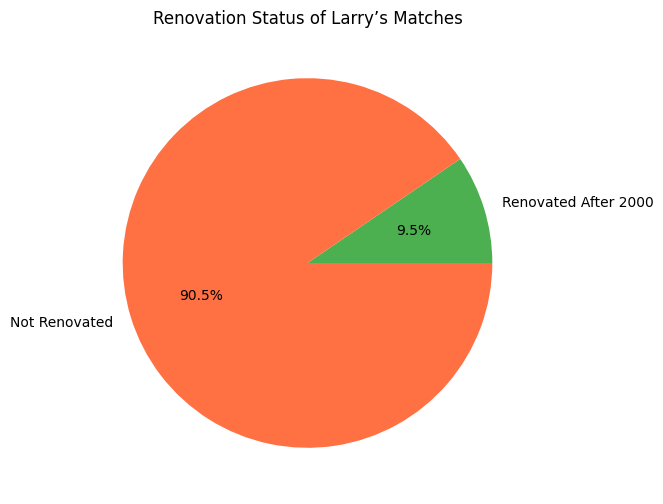

In [ ]:
labels = ['Renovated After 2000', 'Not Renovated']
sizes = [recent_renovations, len(larry_houses) - recent_renovations]

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['#4CAF50', '#FF7043'])
plt.title('Renovation Status of Larry’s Matches')
plt.show()
